# Exploring 1st Iteration Data

### Setup

In [1]:
# General Imports
import nltk
import random

In [2]:
# Add path to custom code
#  This is a bit of a hack to add the directory, in a general way, to path to load code
#  This hack
import os
import sys

# Set project related paths
base_path = os.path.dirname(os.getcwd())
dat_path = os.path.join(base_path, 'Data')

In [3]:
# Import custom code
sys.path.append(base_path)
from consc.data import load_folder

### Functions

These are some quick functions to work with the data

In [4]:
from itertools import chain

In [5]:
def get_all_words(dat, field):
    
    all_words = [getattr(doc, field) for doc in dat] # for doc in all_docs]
    all_words = list(chain.from_iterable(all_words))
    
    return all_words

### Loading

In [6]:
# Load the data
paper_dat = load_folder('Papers', 'dementia', dat_path)

# This is a hack to force load a particular folder, to get started.
#  I'm not sure, what the intended way to load all PRs is - fix this when sorted.
press_dat = load_folder('PRs', 'dementia', dat_path)

#### Sanity Check Loaded Data

In [7]:
# Check data sizes
print(len(paper_dat))
print(len(press_dat))
# Note: each of these elements is itself a list of objects

493
391


### Pre-Processing

In [8]:
# Collapse across all words in a given data type
all_paper_words = get_all_words(paper_dat, 'words')
all_press_words = get_all_words(press_dat, 'words')

print(len(all_paper_words))
print(len(all_press_words))

59271
134639


### NLTK 

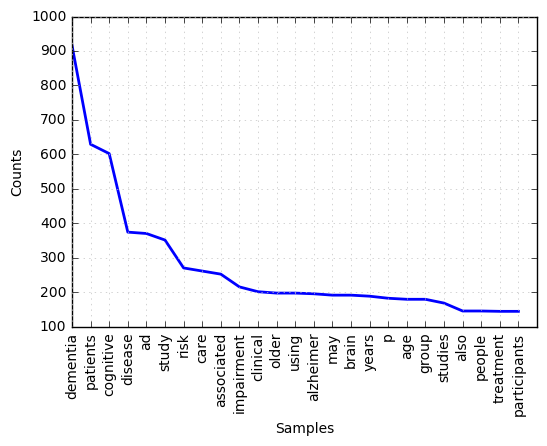

In [9]:
# Create and plot the frequency distribution of words - papers
paper_fd = nltk.FreqDist(all_paper_words)
paper_fd.plot(25)

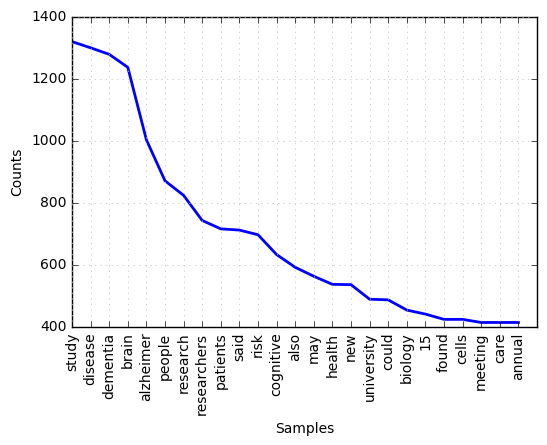

In [13]:
# Create and plot the frequency distribution of words - PRs
press_fd = nltk.FreqDist(all_press_words)
press_fd.plot(25)

### Sentence Polarity

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [15]:
paper_polarities = []

for p in paper_dat:
    for sent in p.sentences:
        paper_polarities.append(sia.polarity_scores(sent)['compound'])

print(len(paper_polarities))

3715


In [16]:
press_polarities = []

for p in press_dat:
    for sent in p.sentences:
        press_polarities.append(sia.polarity_scores(sent)['compound'])
        
print(len(press_polarities))

7173


In [17]:
# Plotting polarity
import matplotlib.pyplot as plt
import numpy as np
import math

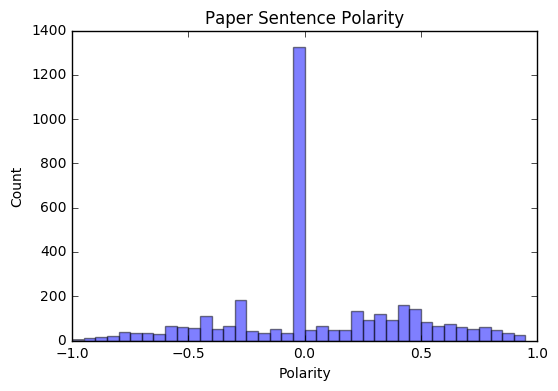

In [18]:
# bins = np.linspace(math.ceil(min(polarities)), 
#                    math.floor(max(polarities)), 20)

bins = np.arange(-1, 1, 0.05)

plt.xlim([-1, 1])

plt.hist(paper_polarities, bins=bins, alpha=0.5)
plt.title('Paper Sentence Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count')

plt.show()

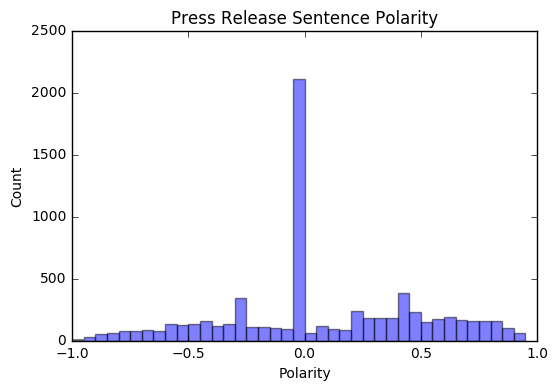

In [19]:
plt.xlim([-1, 1])

plt.hist(press_polarities, bins=bins, alpha=0.5)
plt.title('Press Release Sentence Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count')

plt.show()

### Readability

### Part of Speech Tagging

In [20]:
# Papers
paper_pos = nltk.pos_tag(all_paper_words)

In [21]:
# Press Releases
press_pos = nltk.pos_tag(all_press_words)

In [22]:
from collections import Counter

In [23]:
counts = Counter(tag for word, tag in paper_pos)
# print(counts)

total = sum(counts.values())

normalized = dict((word, float(count) / total) for word,count in counts.items())
print(normalized)

{'CC': 0.0007086096067216683, 'NNS': 0.1495334986755749, 'TO': 3.3743314605793726e-05, 'JJR': 0.007254812640245651, 'MD': 0.005550775252653068, 'WRB': 6.748662921158745e-05, 'RBS': 0.00016871657302896864, 'RBR': 0.0018390106460157581, 'FW': 0.003323716488670682, 'VBN': 0.031111336066541817, 'NNP': 0.005027753876263265, 'VBG': 0.03760692412815711, '$': 0.00011810160112027804, "''": 1.6871657302896863e-05, 'IN': 0.012873074522110306, 'RB': 0.03812994550454691, 'VBD': 0.04648141586948086, 'VB': 0.00990366283680046, 'SYM': 1.6871657302896863e-05, 'DT': 0.00028681817414924666, 'CD': 0.03478935735857333, 'VBP': 0.042584063032511686, 'PRP': 0.0002699465168463498, 'JJ': 0.21577162524674798, 'WDT': 1.6871657302896863e-05, 'RP': 0.00015184491572607179, 'NN': 0.34178603364208465, 'JJS': 0.001467834185352027, 'VBZ': 0.012991176123230586, 'WP$': 0.00010122994381738119, 'UH': 1.6871657302896863e-05}


In [24]:
total = len(all_paper_words)

In [25]:
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer

In [26]:
print(subjectivity)

sa = SentimentAnalyzer()
feats = sa.extract_features(paper_dat[0].text)
print(feats)

<CategorizedSentencesCorpusReader in '.../corpora/subjectivity' (not loaded yet)>
{}


# Liu Hu Lexicon

### Helper Functions

In [31]:
import re
NEGATION = r"""
    (?:
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint
        )$
    )
    |
    n't"""

NEGATION_RE = re.compile(NEGATION, re.VERBOSE)

CLAUSE_PUNCT = r'^[.:;!?]$'
CLAUSE_PUNCT_RE = re.compile(CLAUSE_PUNCT)

def _show_plot(x_values, y_values, x_labels=None, y_labels=None):
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError('The plot function requires matplotlib to be installed.'
                         'See http://matplotlib.org/')

    plt.locator_params(axis='y', nbins=3)
    axes = plt.axes()
    axes.yaxis.grid()
    plt.plot(x_values, y_values, 'ro', color='red')
    plt.ylim(ymin=-1.2, ymax=1.2)
    plt.tight_layout(pad=5)
    if x_labels:
        plt.xticks(x_values, x_labels, rotation='vertical')
    if y_labels:
        plt.yticks([-1, 0, 1], y_labels, rotation='horizontal')
    # Pad margins so that markers are not clipped by the axes
    plt.margins(0.2)
    plt.show()
    
def mark_negation(document, double_neg_flip=False, shallow=False):
    """
    Append _NEG suffix to words that appear in the scope between a negation
    and a punctuation mark.

    :param document: a list of words/tokens, or a tuple (words, label).
    :param shallow: if True, the method will modify the original document in place.
    :param double_neg_flip: if True, double negation is considered affirmation
        (we activate/deactivate negation scope everytime we find a negation).
    :return: if `shallow == True` the method will modify the original document
        and return it. If `shallow == False` the method will return a modified
        document, leaving the original unmodified.

    >>> sent = "I didn't like this movie . It was bad .".split()
    >>> mark_negation(sent)
    ['I', "didn't", 'like_NEG', 'this_NEG', 'movie_NEG', '.', 'It', 'was', 'bad', '.']
    """
    if not shallow:
        document = deepcopy(document)
    # check if the document is labeled. If so, do not consider the label.
    labeled = document and isinstance(document[0], (tuple, list))
    if labeled:
        doc = document[0]
    else:
        doc = document
    neg_scope = False
    for i, word in enumerate(doc):
        if NEGATION_RE.search(word):
            if not neg_scope or (neg_scope and double_neg_flip):
                neg_scope = not neg_scope
                continue
            else:
                doc[i] += '_NEG'
        elif neg_scope and CLAUSE_PUNCT_RE.search(word):
            neg_scope = not neg_scope
        elif neg_scope and not CLAUSE_PUNCT_RE.search(word):
            doc[i] += '_NEG'

    return document


def output_markdown(filename, **kwargs):
    """
    Write the output of an analysis to a file.
    """
    with codecs.open(filename, 'at') as outfile:
        text = '\n*** \n\n'
        text += '{0} \n\n'.format(time.strftime("%d/%m/%Y, %H:%M"))
        for k in sorted(kwargs):
            if isinstance(kwargs[k], dict):
                dictionary = kwargs[k]
                text += '  - **{0}:**\n'.format(k)
                for entry in sorted(dictionary):
                    text += '    - {0}: {1} \n'.format(entry, dictionary[entry])
            elif isinstance(kwargs[k], list):
                text += '  - **{0}:**\n'.format(k)
                for entry in kwargs[k]:
                    text += '    - {0}\n'.format(entry)
            else:
                text += '  - **{0}:** {1} \n'.format(k, kwargs[k])
        outfile.write(text)


def save_file(content, filename):
    """
    Store `content` in `filename`. Can be used to store a SentimentAnalyzer.
    """
    print("Saving", filename)
    with codecs.open(filename, 'wb') as storage_file:
        # The protocol=2 parameter is for python2 compatibility
        pickle.dump(content, storage_file, protocol=2)


def split_train_test(all_instances, n=None):
    """
    Randomly split `n` instances of the dataset into train and test sets.

    :param all_instances: a list of instances (e.g. documents) that will be split.
    :param n: the number of instances to consider (in case we want to use only a
        subset).
    :return: two lists of instances. Train set is 8/10 of the total and test set
        is 2/10 of the total.
    """
    random.seed(12345)
    random.shuffle(all_instances)
    if not n or n > len(all_instances):
        n = len(all_instances)
    train_set = all_instances[:int(.8*n)]
    test_set = all_instances[int(.8*n):n]

    return train_set, test_set

### Feature Extraction

In [32]:
def extract_unigram_feats(document, unigrams, handle_negation=False):
    """
    Populate a dictionary of unigram features, reflecting the presence/absence in
    the document of each of the tokens in `unigrams`.

    :param document: a list of words/tokens.
    :param unigrams: a list of words/tokens whose presence/absence has to be
        checked in `document`.
    :param handle_negation: if `handle_negation == True` apply `mark_negation`
        method to `document` before checking for unigram presence/absence.
    :return: a dictionary of unigram features {unigram : boolean}.

    >>> words = ['ice', 'police', 'riot']
    >>> document = 'ice is melting due to global warming'.split()
    >>> sorted(extract_unigram_feats(document, words).items())
    [('contains(ice)', True), ('contains(police)', False), ('contains(riot)', False)]
    """
    features = {}
    if handle_negation:
        document = mark_negation(document)
    for word in unigrams:
        features['contains({0})'.format(word)] = word in set(document)
    return features


def extract_bigram_feats(document, bigrams):
    """
    Populate a dictionary of bigram features, reflecting the presence/absence in
    the document of each of the tokens in `bigrams`. This extractor function only
    considers contiguous bigrams obtained by `nltk.bigrams`.

    :param document: a list of words/tokens.
    :param unigrams: a list of bigrams whose presence/absence has to be
        checked in `document`.
    :return: a dictionary of bigram features {bigram : boolean}.

    >>> bigrams = [('global', 'warming'), ('police', 'prevented'), ('love', 'you')]
    >>> document = 'ice is melting due to global warming'.split()
    >>> sorted(extract_bigram_feats(document, bigrams).items())
    [('contains(global - warming)', True), ('contains(love - you)', False),
    ('contains(police - prevented)', False)]
    """
    features = {}
    for bigr in bigrams:
        features['contains({0} - {1})'.format(bigr[0], bigr[1])] = bigr in nltk.bigrams(document)
    return features

### Real Liu Hu Analysis

In [33]:
def liu_hu_lexicon(sentence, plot=False):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral

    if plot == True:
        _show_plot(x, y, x_labels=tokenized_sent, y_labels=['Negative', 'Neutral', 'Positive'])
            
    if pos_words > neg_words:
        print('Positive')
        return 'pos'
    elif pos_words < neg_words:
        print('Negative')
        return 'neg'
    elif pos_words == neg_words:
        print('Neutral')
        return 'neu'

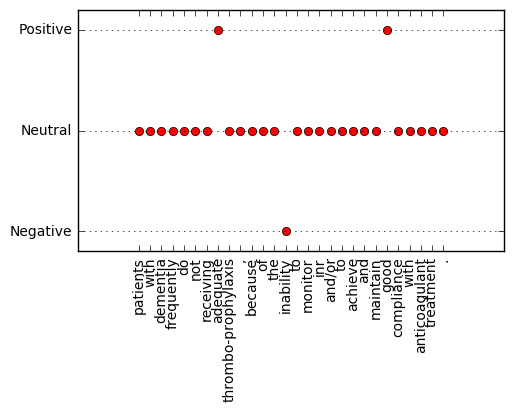

Positive


'pos'

In [34]:
liu_hu_lexicon(paper_dat[0].sentences[1], True)

# Subjectivity

In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC

import codecs
import csv
import json
import pickle
import random
import re
import sys
import time
from copy import deepcopy
from itertools import tee

import nltk
from nltk.corpus import CategorizedPlaintextCorpusReader
from nltk.data import load
from nltk.tokenize.casual import EMOTICON_RE


def demo_subjectivity(trainer, save_analyzer=False, n_instances=None, output=None):
    """
    Train and test a classifier on instances of the Subjective Dataset by Pang and
    Lee. The dataset is made of 5000 subjective and 5000 objective sentences.
    All tokens (words and punctuation marks) are separated by a whitespace, so
    we use the basic WhitespaceTokenizer to parse the data.

    :param trainer: `train` method of a classifier.
    :param save_analyzer: if `True`, store the SentimentAnalyzer in a pickle file.
    :param n_instances: the number of total sentences that have to be used for
        training and testing. Sentences will be equally split between positive
        and negative.
    :param output: the output file where results have to be reported.
    """
    from nltk.sentiment import SentimentAnalyzer
    from nltk.corpus import subjectivity

    if n_instances is not None:
        n_instances = int(n_instances/2)

    subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
    obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

    # We separately split subjective and objective instances to keep a balanced
    # uniform class distribution in both train and test sets.
    train_subj_docs, test_subj_docs = split_train_test(subj_docs)
    train_obj_docs, test_obj_docs = split_train_test(obj_docs)

    training_docs = train_subj_docs+train_obj_docs
    testing_docs = test_subj_docs+test_obj_docs

    sentim_analyzer = SentimentAnalyzer()
    all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

    # Add simple unigram word features handling negation
    unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
    sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

    # Apply features to obtain a feature-value representation of our datasets
    training_set = sentim_analyzer.apply_features(training_docs)
    test_set = sentim_analyzer.apply_features(testing_docs)

    classifier = sentim_analyzer.train(trainer, training_set)
    try:
        classifier.show_most_informative_features()
    except AttributeError:
        print('Your classifier does not provide a show_most_informative_features() method.')
    results = sentim_analyzer.evaluate(test_set)

    if save_analyzer == True:
        save_file(sentim_analyzer, 'sa_subjectivity.pickle')

    if output:
        extr = [f.__name__ for f in sentim_analyzer.feat_extractors]
        output_markdown(output, Dataset='subjectivity', Classifier=type(classifier).__name__,
                        Tokenizer='WhitespaceTokenizer', Feats=extr,
                        Instances=n_instances, Results=results)

    return sentim_analyzer

In [ ]:
svm = SklearnClassifier(LinearSVC()).train
sa = demo_subjectivity(svm)

In [ ]:
# Have to train if we want it to work

def demo_sent_subjectivity(text):
    """
    Classify a single sentence as subjective or objective using a stored
    SentimentAnalyzer.

    :param text: a sentence whose subjectivity has to be classified.
    """
    from nltk.classify import NaiveBayesClassifier
    from nltk.tokenize import regexp
    word_tokenizer = regexp.WhitespaceTokenizer()
    try:
        sentim_analyzer = load('sa_subjectivity.pickle')
    except LookupError:
        print('Cannot find the sentiment analyzer you want to load.')
        print('Training a new one using NaiveBayesClassifier.')
        sentim_analyzer = demo_subjectivity(NaiveBayesClassifier.train, True)

    # Tokenize and convert to lower case
    tokenized_text = [word.lower() for word in word_tokenizer.tokenize(text)]
    print(sentim_analyzer.classify(tokenized_text))